# Classifing audio data with convolutional neural networks

## Data pre-processing

In this second notebook we are going evaluate how to convert our audio files to the same format to ensure we are working with consistent data. Then we'll discuss on feature extraction techniques and what is the best tool for the job.<br/>
<br/>

### Setup
Pay attention to the very simple path variables configured in this section.

In [4]:
# Required libraries
import sys
import os
import IPython as IP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [5]:
# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')

# General settings
general_sample_rate = 22050

#### Helper functions

In [55]:
# Helper: Generates MFCC coefficients with Librosa 
def get_mfcc(filename, mfcc_max_padding=0):
    try:
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = mfcc_max_padding - mfccs.shape[1]
        
        # Should we require padding
        if (mfcc_max_padding > 0 & mfccs.shape[1] < mfcc_max_padding):
            pad_width = mfcc_max_padding - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", filename)
        return None 
    return mfccs


#### Load metadata

In [5]:
# Load the metadata from the generated CSV
metadata = pd.read_csv(metadata_path)

# Examine dataframe
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Standarisation of digital audio
Working with convolutions and audio data can be very different than working with image data. Actually, it can be more chanlenging.<br/>
<br/>
Ill try to give a brief explanation and later proposse reading material for if you like to investigate more in depth.<br/>
<br/>
As we already saw in the previous exploration we have a significant variance between the different audio properties (sample rate, bit depth, duration). There are some very important considerations we must take care of:<br/>
<br/>
#### Sample Rate
Higher sample rates also mean wider frequency ranges. The higher the sample rate used to record a sound, the more frequencies being captured. More precisely, according to the [Nyquist Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), the highest frequency that can be captured in a recording is equal to the recording sample rate / 2, for example, while recording at 48.000 khz only frequencies up to 22.200 khz can be captured. This will also apply to resampling: while a 44.100 khz audio may contain frequencies up to 22.050 khz, when resampled to 22.050 khz the new file will contain half that range: up to 11.025 khz.<br/>
<br/>
At the same time, most of the recognizable changes in sound will occur in the lower frequencies and we can downsample to 22.050 khz, reducing the volume of data while still preserving the patterns our CNN will recognize.<br/>
<br/>
I strongly recommend to read this [well explained audio sampling material](http://support.ircam.fr/docs/AudioSculpt/3.0/co/Sampling.html)<br/>
<br/>

*Note that resampling audio may incurr in what is known as Aliassing. To overcome this common problem converters use "Anti Aliassing Filters". It is crucial that we use a conversor with well-implemented filters or the required audio features will be "corrupted" after the process, hence, wrong pattern recognition.*<br/>

<br/>

#### Bit Depth
Different bit depths mean higher resolution but also different scales. Converting bit depths is not problematic as converting sample rate (*see below).<br/>

<br/>

#### Max Amplitude 
Each sound file will usually have a differente maximum point of amplitude. Ideally, we'd like to normalize this amplitude values to fit the same scale between all samples.<br/>
<br/>

#### Duration  
A convolutional neural network requires to be feeded with spatially related data. Images are a good example: if you change the order of columns or rows, the position of pixels change and the information does not describe the originall image anymore. Similarly, different image sizes imply different spatial configurations.<br/>
<br/>
In sound we have that strict relation between frequencies and amplitudes over time, and having dataset of varying sound durations means varying input vector sizes to feed our CNN. To overcome this problem we'll use padding: for all the samples of length less than the maximum length in our data collection, we'll fill up space with zeros until we reach that maximum value. This is a commonly used technique and it does not alter the performance of the network.<br/>
<br/>

#### The good news
Loading files with Librosa will automatically convert audio to 22.050 khz and 16 bit with tested quality audio conversion. Also, the data values will be normalized between 0 and 1. Using librosa, we just need to load files and we are almost ready to work with the data.

The only disadvantage of Librosa, as a native Python implementation, is that it's much slower than ffmpeg to convert, and also much slower to extract audio features than a C++ library. But having tested with other audio libraries -like Essentia, a super fast C++ library with Python bindings- I can tell the audio features extracted with Librosa prooved to achieve higher scores, so I decided to sacrifice speed/time for qualilty.

### Feature extraction: MFCC
Extraction of Mel Frquency Cepstral Coefficients from the RAW audio

It is proved that you can feed a CNN with raw audio data and by doing 1D convolution the network is capable of finding patterns. Even thought, there are more efficient methods like feeding the CNN with the coeficients of the sound's spectograms. A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.
This showed better performance than using raw data.

The typical spectrogram has one disadvantage: it uses a linear frequency scaling, so each frequency bin is spaced the equal number of Hertz apart. And here is how the MFCC comes in: the mel-frequency scale, on the other hand, is a quasi-logarithmic spacing roughly resembling the resolution of the human auditory system.

For more detailed information [check this article](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).<br/>
<br/>

#### Example Mel Spectogram of random file

File: /home/edu/Projects/nn-audio-classifier/UrbanSound8K/audio/fold1/135776-2-0-85.wav
Category: children_playing


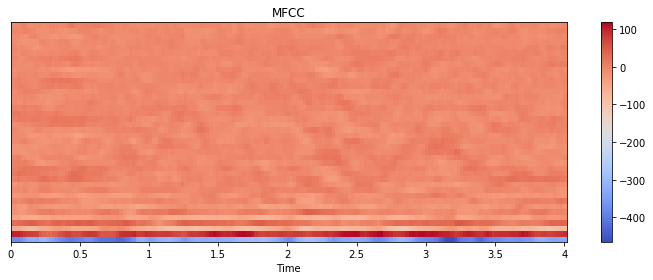

In [56]:
# Get a random file
row = metadata.sample(1)
fold_num = str(row.iloc[0,5])
file_name = str(row.iloc[0,0])
category = str(row.iloc[0,7])
file_path = audio_path + '/fold'+ fold_num +'/' + file_name

# Display info
print("File: "+ file_path)
print("Category: "+ category)

# Extract MFCCs from audio
mfccs = get_mfcc(file_path)

# Plot the MEL Spectogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

#### Full dataset MFCC extraction

In [131]:
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(metadata)

for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(resample_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]
    mfccs = get_mfcc(file_name)    
    num_frames = mfccs.shape[1]
    
    # Add row (feature / label)
    features.append(mfccs)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 100):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0
    
    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 100/8732
Status: 200/8732
Status: 300/8732
Status: 400/8732
Status: 500/8732
Status: 600/8732
Status: 700/8732
Status: 800/8732
Status: 900/8732
Status: 1000/8732
Status: 1100/8732
Status: 1200/8732
Status: 1300/8732
Status: 1400/8732
Status: 1500/8732
Status: 1600/8732
Status: 1700/8732
Status: 1800/8732
Status: 1900/8732
Status: 2000/8732
Status: 2100/8732
Status: 2200/8732
Status: 2300/8732
Status: 2400/8732
Status: 2500/8732
Status: 2600/8732
Status: 2700/8732
Status: 2800/8732
Status: 2900/8732
Status: 3000/8732
Status: 3100/8732
Status: 3200/8732
Status: 3300/8732
Status: 3400/8732
Status: 3500/8732
Status: 3600/8732
Status: 3700/8732
Status: 3800/8732
Status: 3900/8732
Status: 4000/8732
Status: 4100/8732
Status: 4200/8732
Status: 4300/8732
Status: 4400/8732
Status: 4500/8732
Status: 4600/8732
Status: 4700/8732
Status: 4800/8732
Status: 4900/8732
Status: 5000/8732
Status: 5100/8732
Status: 5200/8732
Status: 5300/8732
Status: 5400/8732
Status: 5500/8732
Status: 5600/8732
S

#### Add padding for a consistent shape

In [153]:
padded = []

# Add padding
mfcc_max_padding = frames_max
for i in range(len(features)):
    size = len(features[i][0])
    if (size < mfcc_max_padding):
        pad_width = mfcc_max_padding - size
        px = np.pad(features[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    padded.append(px)

### Data Scaling


In [ ]:
# PENDING

#### Save X and y

In [156]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded)
y = np.array(labels)

# Optionally save the features to disk
np.save("data/X", X)
np.save("data/y", y)

In [157]:
# Load saved data instead...
#X = np.load("data/X.npy")
#y = np.load("data/y.npy")

In [174]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded)))
print("Feature labels length: {}".format(len(features)))
print("X: {}, y: {}".format(X.shape, y.shape))


Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732
X: (8732, 40, 174), y: (8732,)
